Final Project -- Lunar Lander DQN Agent with OpenAI Gym
---------
Josh White<br/>
CSPB 3202 - Artificial Intelligence<br/>
8/9/2022<br/>
Github: https://github.com/joshiswhite19/CSPB3202_FinalProject<br/>
YouTube: https://youtu.be/lxhsVeLDT4I

# Project Overview

For my final project, I decided to create a reinforcement learning agent which can efficiently complete the Lunar Lander environment in OpenAI Gym. The agent will use a Deep-Q Network (DQN) to map the Lunar Lander environment to the available actions in a repeatable and efficient way. Once the agent has been defined, I will test several neural network models of varying dense layer amounts and sizes to see which one is able to converge on a consistent passing score of 200 points the quickest. From there, I will take the best model and tune it even further by training over several ranges of hyperparameter values until I've come across the best Lunar Lander model possible. At the end of all this model refinement, I will test the final solution on the game and see how it performs live.

## Lunar Lander Environment

From the environment overview page on the OpenAI Gym site, the characteristics of the environment are described as follows:

### Action Space

The environment has the following four discrete actions:

| Discrete Num | Action                        |
|--------------|-------------------------------|
| 0            | Do nothing                    |
| 1            | Fire left orientation engine  |
| 2            | Fire main engine              |
| 3            | Fire right orientation engine |

### Observation Space

The environment state space is described by the following 8 elements:

- Lander x and y position
- Lander x and y linear velocity
- Lander angle
- Lander angular velocity
- Lander left and right leg ground contact booleans

### Reward System

The agent receives the following rewards from the environment:

| Event                   | Reward      |
|-------------------------|-------------|
| Lander Crash            | -100        |
| Lander Comes to Rest    | +100        |
| Leg Contact with Ground | +10/leg     |
| Main Engine Fire        | -0.3/frame  |
| Side Engine Fire.       | -0.03/frame |
| Solved                  | +200        |

### Start State and Termination Events

The agent starts at the top center of the screen with a random initial force applied. An episode will terminate if any of the following events occur:

- The lander crashes
- The lander travels outside the screen
- The lander is no longer awake (i.e. it isn't moving or colliding with another body)


# Approach

To solve the lunar lander environment, I will implement a Deep-Q Network (DQN) agent. A DQN merges the functionality of a neural network with a reinforcement Q-learning agent as a convenient way to map inputs from all 8 of the environment variables to all 4 of the agent actions. I chose to use this method because it seemed like the best way to demonstrate all the concepts covered during the course, and it seems to me like DQN is going to be a method that will be very useful to know in the future. It is also the quickest way to create a model for any reinforcement learning environment, regardless of the state space and agent actions available.

There are a few additional considerations that need to be addressed to make this system work, however. In typical Q-learninig, the Q' term is estimated given the environment, but this estimation is too heavily correlated on the previous time step for the neural network to not diverge away from a solution. In order to remove this inaccuracy, a second network is maintained and sampled from to provide the estimated Q'. This "replay buffer" is a rolling buffer of given size that is sampled in batches and updated at a defined frequency to keep it mostly up to date with the local training network.

In the code I implemented below, I referenced a few sources heavily to ensure I had the replay buffer and DQN implementation correct. Since this was my first time using pytorch and DQN, it was very helpful and necessary for me to have these helpful sources to understand how the system works. I made sure to implement methods for quickly adjusting the neural network model and the hyperparameters so that I could explore the most optimal model.

# Code Implementation

In [14]:
# Library Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from gym import wrappers
import random
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple
import os
import gc

In [15]:
WINNING_SCORE = 200

### Neural Network Definitions

In [16]:
class QNet_64(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet_64, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [17]:
class QNet_64_64(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet_64_64, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return self.fc4(x)

In [18]:
class QNet_64_64_32(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet_64_64_32, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return self.fc5(x)

In [19]:
class QNet_64_32_32(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet_64_32_32, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return self.fc5(x)

In [20]:
class QNet_512_256_128_64(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet_512_256_128_64, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return self.fc5(x)

In [21]:
class QNet_32(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet_32, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [22]:
class QNet_64_32(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNet_64_32, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Agent Class Definition

In [23]:
# Define general DQN agent class which access to q-net and takes gym env params as input
class Agent():
    #Initialize an Agent object
    def __init__(self, n_observations, n_actions, qnet_func, alpha, gamma, replay_buff_size, replay_buff_batch_size):
        
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.lr = alpha
        self.discount = gamma
        self.tau = 1e-3
        self.update_freq = 4
        self.t = 0

        self.qnet_local = qnet_func(n_observations, n_actions)
        self.qnet_target = qnet_func(n_observations, n_actions)
        self.optimizer = optim.Adam(self.qnet_local.parameters(), lr=self.lr)

        self.replay_buff = ReplayBuffer(n_actions, replay_buff_size, replay_buff_batch_size)
    
    # Save parameters for the next step to the buffer, train 
    def step(self, s, a, r, s_prime, done):
        # Save step in replay buffer
        self.replay_buff.add(s, a, r, s_prime, done)
        
        # Update the model every time it rolls over, i.e. the update frequency
        self.t = (self.t + 1) % self.update_freq
        if self.t == 0:
            # If enough samples are available in the buffer, get random subset and update with it
            if len(self.replay_buff) > self.replay_buff.batch_size:
                replay_samples = self.replay_buff.sample()
                self.update(replay_samples, self.discount)

    # Chooses an action based on provided state
    def choose_action(self, state, eps=0, test=False):
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnet_local.eval()
        with torch.no_grad():
            actions = self.qnet_local(state)
        
        if test:
            return np.argmax(actions.cpu().data.numpy())
        
        self.qnet_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(actions.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_actions))

    # Update Q values using sample from replay buffer
    def update(self, replays, gamma):
        # Obtain random subset of tuples from replay buffer
        states, actions, rewards, state_primes, dones = replays

        # Get expected Q' using target q-net and the Bellman equation
        q_primes_target = self.qnet_target(state_primes).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_primes_target * (1 - dones)
        q_expected = self.qnet_local(states).gather(1, actions)
        
        # Compute loss between expected and target using mean squared error, then step through optimizer
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.update_target(self.qnet_local, self.qnet_target)                     

    # Update the target model given temperature coefficient
    def update_target(self, model_local, model_target):
        for target_param, local_param in zip(model_target.parameters(), model_local.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
            
    # Save a checkpoint of model, garbage collect and reload model. Attempt at clearing memory during training
    def refresh_model_cache(self):
        torch.save({
            "model_local_state_dict": self.qnet_local.state_dict(),
            "model_target_state_dict": self.qnet_target.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict()
        }, "model.pt")
        gc.collect()
        reload = torch.load("model.pt")
        self.qnet_local.load_state_dict(reload["model_local_state_dict"])
        self.qnet_target.load_state_dict(reload["model_target_state_dict"])
        self.optimizer.load_state_dict(reload["optimizer_state_dict"])
        

In [24]:
# Define class for a size-constrained buffer for implementing experience replay for DQN
class ReplayBuffer:
    # Initialize the ReplayBuffer
    def __init__(self, n_actions, buff_size, batch_size):
        
        self.n_actions = n_actions
        # Data structure for buffer memory
        self.buffer = deque(maxlen=buff_size)
        self.batch_size = batch_size
        # Single experience element of buffer {state, action, reward, state_prime, done}
        self.experience = namedtuple("Experience", field_names=["s", "a", "r", "s_prime", "done"])
    
    # Append a new experience element to the buffer
    def add(self, s, a, r, s_prime, done):
        self.buffer.append(self.experience(s, a, r, s_prime, done))
    
    # Return random sample from the buffer
    def sample(self):
        e_batch = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.s for e in e_batch if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.a for e in e_batch if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.r for e in e_batch if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.s_prime for e in e_batch if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in e_batch if e is not None]).astype(np.uint8)).float()
  
        return (states, actions, rewards, next_states, dones)

    #Return the current size of the buffer
    def __len__(self):
        return len(self.buffer)
    

In [25]:
def train_dqn(outputModelName, n_epochs=2000, max_t=1000, epsilon_decay=0.995):
    scores = []                              # list containing scores from each episode
    scores_window = deque(maxlen=100)        # quick way to track last 100 scores
    epsilon = 1                              # initialize epsilon
    for epoch in range(1, n_epochs+1):
        s = env.reset()
        score = 0
        # Run through max_t time steps of model for a given epoch
        for t in range(max_t):
            a = agent.choose_action(s, epsilon)
            s_prime, r, done, _ = env.step(a)
            agent.step(s, a, r, s_prime, done)
            s = s_prime
            score += r
            if done:
                break 
        # save most recent score
        scores_window.append(score)       
        scores.append(score)             
        avg_score = np.mean(scores_window)
        # Adjust exploration rate
        epsilon = max(.01, epsilon_decay*epsilon)
        print('\rEpoch {}\tAverage Score: {:.2f}'.format(epoch, avg_score), end="")
        if epoch % 100 == 0:
            print('\rEpoch {}\tAverage Score: {:.2f}'.format(epoch, avg_score))
            #agent.refresh_model_cache()
        if avg_score>=WINNING_SCORE:
            print('\nEnvironment solved in {:d} epochs!\tAverage Score: {:.2f}'.format(epoch, avg_score))
            torch.save(agent.qnet_local.state_dict(), f'{outputModelName}.pth')
            break
    return scores


## Model Training
### Model Comparison
The first thing I will do to refine my model is to tune the neural network itself. I will play around with the amount and size of dense layers used in the network and see which one is able to reach a game-winning score the quickest. That one will be taken and used to tune a few other hyperparameters like learning rate, decay rate and exploration decay rate.

In [13]:
env = gym.make('LunarLander-v2')

In [280]:
# Parameter defs
LR = 5e-4                       # learning rate 
REPLAY_BUFFER_SIZE = int(1e5)   # replay buffer size
REPLAY_BUFFER_BATCH_SIZE = 64   # minibatch size
GAMMA = 0.99                    # discount factor 

Epoch 100	Average Score: -189.14
Epoch 200	Average Score: -151.96
Epoch 300	Average Score: -144.18
Epoch 400	Average Score: -36.648
Epoch 500	Average Score: -40.23
Epoch 600	Average Score: -36.88
Epoch 700	Average Score: -92.115
Epoch 800	Average Score: 25.081
Epoch 900	Average Score: 34.12
Epoch 1000	Average Score: -5.85
Epoch 1100	Average Score: -2.715
Epoch 1200	Average Score: -55.66
Epoch 1300	Average Score: -43.62
Epoch 1400	Average Score: -14.43
Epoch 1500	Average Score: 1.5629
Epoch 1600	Average Score: 9.108
Epoch 1700	Average Score: 75.59
Epoch 1800	Average Score: 143.41
Epoch 1900	Average Score: 136.49
Epoch 2000	Average Score: 141.46


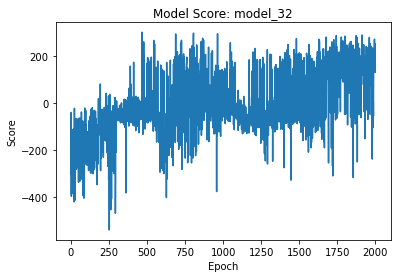

In [281]:
# Qnet_32 training
agent = Agent(
    n_observations = env.observation_space.shape[0],
    n_actions = env.action_space.n,
    qnet_func = QNet_32,
    alpha = LR,
    gamma = GAMMA,
    replay_buff_size = REPLAY_BUFFER_SIZE,
    replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
)
scores_32 = train_dqn("model_32")
plt.plot(scores_32)
plt.title("Model Score: model_32")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

Epoch 100	Average Score: -168.20
Epoch 200	Average Score: -81.694
Epoch 300	Average Score: -100.54
Epoch 400	Average Score: -24.50
Epoch 500	Average Score: 43.774
Epoch 600	Average Score: 140.51
Epoch 700	Average Score: 194.09
Epoch 703	Average Score: 200.30
Environment solved in 703 epochs!	Average Score: 200.30


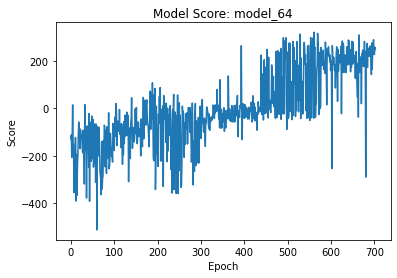

In [292]:
# Qnet_64 training
agent = Agent(
    n_observations = env.observation_space.shape[0],
    n_actions = env.action_space.n,
    qnet_func = QNet_64,
    alpha = LR,
    gamma = GAMMA,
    replay_buff_size = REPLAY_BUFFER_SIZE,
    replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
)
scores_64 = train_dqn("model_64")
plt.plot(scores_64)
plt.title("Model Score: model_64")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

Epoch 100	Average Score: -164.37
Epoch 200	Average Score: -136.19
Epoch 300	Average Score: -28.231
Epoch 400	Average Score: 8.0481
Epoch 500	Average Score: 75.95
Epoch 600	Average Score: 150.67
Epoch 689	Average Score: 200.08
Environment solved in 689 epochs!	Average Score: 200.08


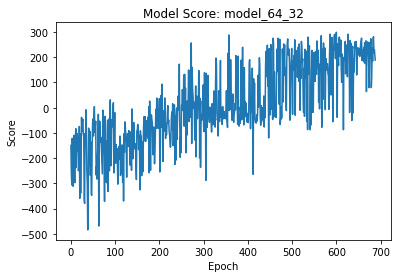

In [293]:
# Qnet_64_32 training
agent = Agent(
    n_observations = env.observation_space.shape[0],
    n_actions = env.action_space.n,
    qnet_func = QNet_64_32,
    alpha = LR,
    gamma = GAMMA,
    replay_buff_size = REPLAY_BUFFER_SIZE,
    replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
)
scores_64_32 = train_dqn("model_64_32")
plt.plot(scores_64_32)
plt.title("Model Score: model_64_32")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

Epoch 100	Average Score: -148.45
Epoch 200	Average Score: -93.103
Epoch 300	Average Score: -59.09
Epoch 400	Average Score: 13.905
Epoch 500	Average Score: 126.61
Epoch 600	Average Score: 172.34
Epoch 700	Average Score: 194.75
Epoch 744	Average Score: 200.69
Environment solved in 744 epochs!	Average Score: 200.69


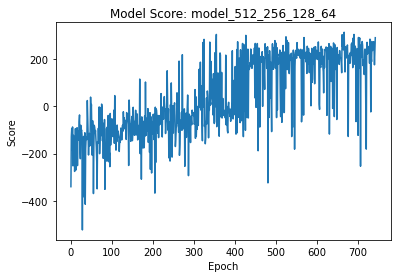

In [296]:
# Qnet_512_256_128_64 training
agent = Agent(
    n_observations = env.observation_space.shape[0],
    n_actions = env.action_space.n,
    qnet_func = QNet_512_256_128_64,
    alpha = LR,
    gamma = GAMMA,
    replay_buff_size = REPLAY_BUFFER_SIZE,
    replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
)
scores_512_256_128_64 = train_dqn("model_512_256_128_64")
plt.plot(scores_512_256_128_64)
plt.title("Model Score: model_512_256_128_64")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

Epoch 100	Average Score: -183.18
Epoch 200	Average Score: -121.56
Epoch 300	Average Score: -118.97
Epoch 400	Average Score: 110.484
Epoch 500	Average Score: 150.48
Epoch 600	Average Score: 100.16
Epoch 700	Average Score: 185.90
Epoch 719	Average Score: 202.80
Environment solved in 719 epochs!	Average Score: 202.80


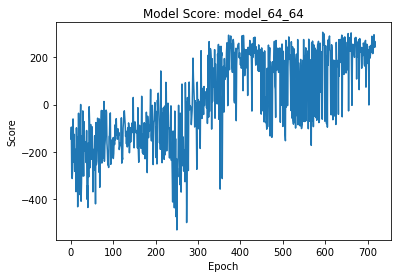

In [303]:
# Qnet_64_64 training
agent = Agent(
    n_observations = env.observation_space.shape[0],
    n_actions = env.action_space.n,
    qnet_func = QNet_64_64,
    alpha = LR,
    gamma = GAMMA,
    replay_buff_size = REPLAY_BUFFER_SIZE,
    replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
)
scores_64_64 = train_dqn("model_64_64")
plt.plot(scores_64_64)
plt.title("Model Score: model_64_64")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

Epoch 100	Average Score: -166.45
Epoch 200	Average Score: -73.954
Epoch 300	Average Score: 13.905
Epoch 400	Average Score: 68.51
Epoch 500	Average Score: 131.44
Epoch 600	Average Score: 122.33
Epoch 700	Average Score: 157.05
Epoch 800	Average Score: 195.94
Epoch 816	Average Score: 200.22
Environment solved in 816 epochs!	Average Score: 200.22


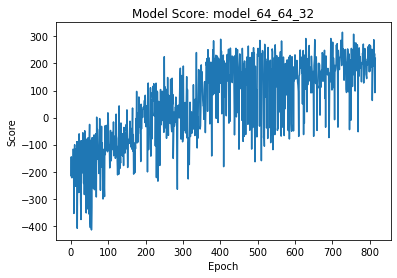

In [304]:
# Qnet_64_64_32 training
agent = Agent(
    n_observations = env.observation_space.shape[0],
    n_actions = env.action_space.n,
    qnet_func = QNet_64_64_32,
    alpha = LR,
    gamma = GAMMA,
    replay_buff_size = REPLAY_BUFFER_SIZE,
    replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
)
scores_64_64_32 = train_dqn("model_64_64_32")
plt.plot(scores_64_64_32)
plt.title("Model Score: model_64_64_32")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

Epoch 100	Average Score: -207.57
Epoch 200	Average Score: -111.24
Epoch 300	Average Score: -35.227
Epoch 400	Average Score: 18.967
Epoch 500	Average Score: 162.41
Epoch 589	Average Score: 200.43
Environment solved in 589 epochs!	Average Score: 200.43


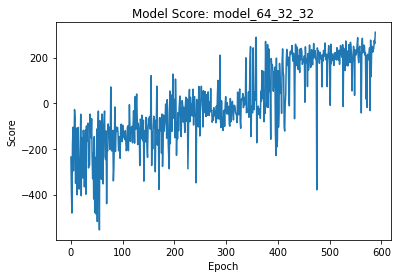

In [306]:
# Qnet_64_32_32 training
agent = Agent(
    n_observations = env.observation_space.shape[0],
    n_actions = env.action_space.n,
    qnet_func = QNet_64_32_32,
    alpha = LR,
    gamma = GAMMA,
    replay_buff_size = REPLAY_BUFFER_SIZE,
    replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
)
scores_64_32_32 = train_dqn("model_64_32_32")
plt.plot(scores_64_32_32)
plt.title("Model Score: model_64_32_32")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

I will plot again all of the models tested so far so we can see which one reached a winning score the quickest:

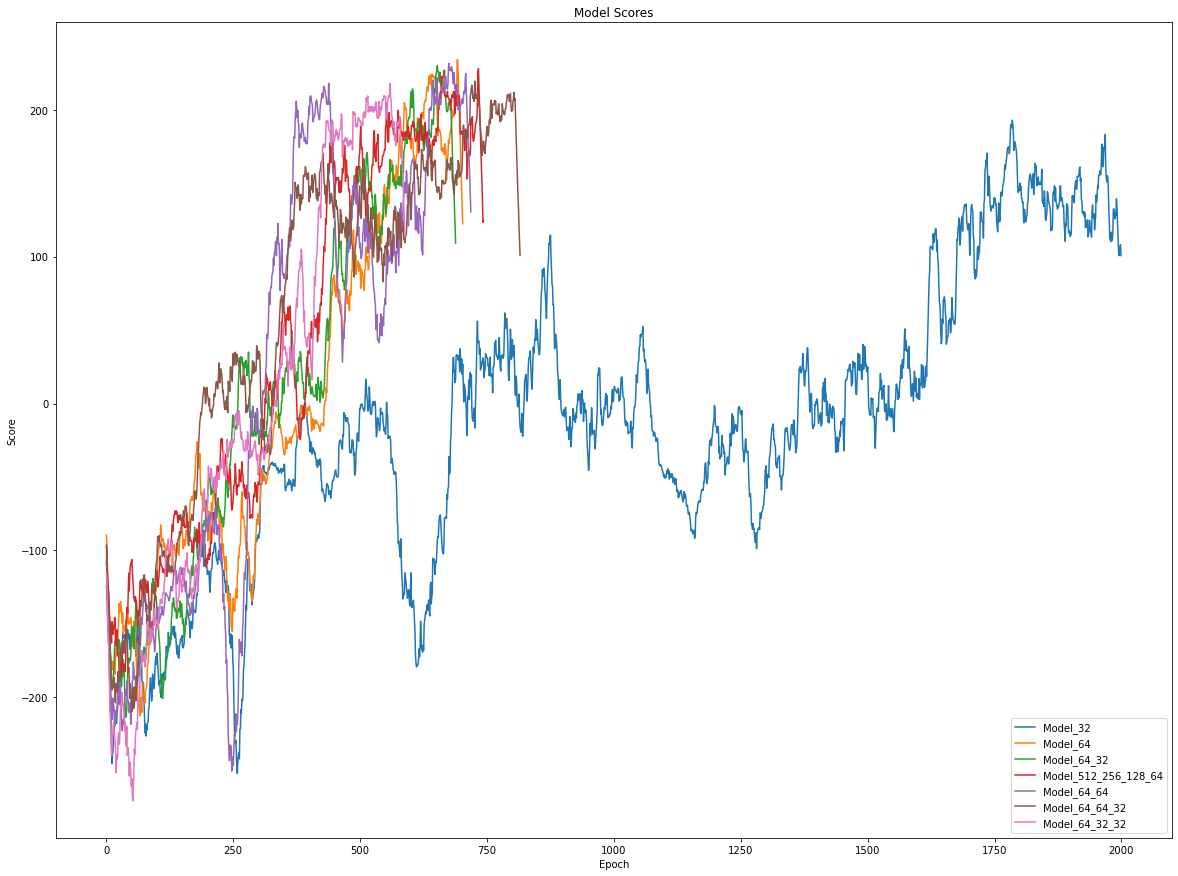

<Figure size 864x360 with 0 Axes>

In [329]:
def smooth_data(data):
    box_pts = 21
    box = np.ones(box_pts)/box_pts
    return np.convolve(data, box, mode='same')

plt.plot(smooth_data(scores_32))
plt.plot(smooth_data(scores_64))
plt.plot(smooth_data(scores_64_32))
plt.plot(smooth_data(scores_512_256_128_64))
plt.plot(smooth_data(scores_64_64))
plt.plot(smooth_data(scores_64_64_32))
plt.plot(smooth_data(scores_64_32_32))
plt.title("Model Scores")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend(["Model_32", "Model_64", "Model_64_32", "Model_512_256_128_64", "Model_64_64", "Model_64_64_32", "Model_64_32_32"], loc="lower right")
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)
plt.show()


From this plot you can see that most models succeeded around the 500-750 epoch range. To get the best idea of which one succeeded the quickest, we can reference this table:

| Model                | Epochs To Completion |
|----------------------|----------------------|
| Model_32             | 2000+                |
| Model_64             | 703                  |
| Model_64_32          | 689                  |
| Model_512_256_128_64 | 744                  |
| Model_64_64          | 719                  |
| Model_64_64_32       | 816                  |
| Model_64_32_32       | 589                  |

From the table, we can see that Model_64_32_32 performed the best, taking only 589 epochs to converge. So I will take that model and try to tune the hyperparameters a bit further to shorten up the train time even more.

### Hyperparameter Tuning

I have put together a range of hyperparameter values to tune with, which the following code will loop through in order to test every possible combination of parameters to see if a specific one works better than the originals trained with. Since the original model trained in only 589 epochs, I will know for sure a given combination is worse when it takes longer than that, so I will set the training loop to only use 900 epochs in order to save time in processing.

In [13]:
env = gym.make('LunarLander-v2')

In [14]:
# Parameter defs
REPLAY_BUFFER_SIZE = int(1e5)   # replay buffer size
REPLAY_BUFFER_BATCH_SIZE = 64   # minibatch size
LR = [.001, .0005, .0001]       # learning rates
GAMMA = [.9, .99, .999]         # discount factors
DECAYS = [.99, .995, .999]      # epsilon decay rates

In [15]:
scores_hyperTuning = {}

lr = LR[0]
for gamma in GAMMA:
    for decay in DECAYS:
        print(f"!!!! BEGIN TUNING RUN FOR lr = {str(lr)}, gamma = {str(gamma)}, decay = {str(decay)} !!!!")
        agent = Agent(
            n_observations = env.observation_space.shape[0],
            n_actions = env.action_space.n,
            qnet_func = QNet_64_32_32,
            alpha = lr,
            gamma = gamma,
            replay_buff_size = REPLAY_BUFFER_SIZE,
            replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
        )
        modelName = f"model_64_32_32_{str(lr)[2:]}_{str(gamma)[2:]}_{str(decay)[2:]}"
        scores_hyperTuning[modelName] = train_dqn(modelName , n_epochs=900, epsilon_decay=decay)

!!!! BEGIN TUNING RUN FOR lr = 0.001, gamma = 0.9, decay = 0.99 !!!!
Epoch 100	Average Score: -154.56
Epoch 200	Average Score: -67.425
Epoch 300	Average Score: -59.88
Epoch 400	Average Score: -109.35
Epoch 500	Average Score: -105.21
Epoch 600	Average Score: -102.90
Epoch 700	Average Score: -97.633
Epoch 800	Average Score: -106.13
Epoch 900	Average Score: -98.161
!!!! BEGIN TUNING RUN FOR lr = 0.001, gamma = 0.9, decay = 0.995 !!!!
Epoch 100	Average Score: -194.19
Epoch 200	Average Score: -138.38
Epoch 300	Average Score: -108.31
Epoch 400	Average Score: -115.30
Epoch 500	Average Score: -94.457
Epoch 600	Average Score: -111.71
Epoch 700	Average Score: -109.96
Epoch 800	Average Score: -108.01
Epoch 900	Average Score: -108.54
!!!! BEGIN TUNING RUN FOR lr = 0.001, gamma = 0.9, decay = 0.999 !!!!
Epoch 100	Average Score: -196.71
Epoch 200	Average Score: -122.36
Epoch 300	Average Score: -111.90
Epoch 400	Average Score: -97.627
Epoch 500	Average Score: -70.08
Epoch 600	Average Score: -76.36
Ep

In [16]:
lr = LR[1]
for gamma in GAMMA:
    for decay in DECAYS:
        print(f"!!!! BEGIN TUNING RUN FOR lr = {str(lr)}, gamma = {str(gamma)}, decay = {str(decay)} !!!!")
        agent = Agent(
            n_observations = env.observation_space.shape[0],
            n_actions = env.action_space.n,
            qnet_func = QNet_64_32_32,
            alpha = lr,
            gamma = gamma,
            replay_buff_size = REPLAY_BUFFER_SIZE,
            replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
        )
        modelName = f"model_64_32_32_{str(lr)[2:]}_{str(gamma)[2:]}_{str(decay)[2:]}"
        scores_hyperTuning[modelName] = train_dqn(modelName , n_epochs=900, epsilon_decay=decay)

!!!! BEGIN TUNING RUN FOR lr = 0.0005, gamma = 0.9, decay = 0.99 !!!!
Epoch 100	Average Score: -186.69
Epoch 200	Average Score: -152.46
Epoch 300	Average Score: -75.711
Epoch 400	Average Score: -97.52
Epoch 500	Average Score: -112.64
Epoch 600	Average Score: -110.09
Epoch 700	Average Score: -128.29
Epoch 800	Average Score: -124.42
Epoch 900	Average Score: -126.70
!!!! BEGIN TUNING RUN FOR lr = 0.0005, gamma = 0.9, decay = 0.995 !!!!
Epoch 100	Average Score: -185.02
Epoch 200	Average Score: -146.76
Epoch 300	Average Score: -91.060
Epoch 400	Average Score: -95.865
Epoch 500	Average Score: -89.112
Epoch 600	Average Score: -95.073
Epoch 700	Average Score: -104.34
Epoch 800	Average Score: -100.05
Epoch 900	Average Score: -100.90
!!!! BEGIN TUNING RUN FOR lr = 0.0005, gamma = 0.9, decay = 0.999 !!!!
Epoch 100	Average Score: -192.49
Epoch 200	Average Score: -186.18
Epoch 300	Average Score: -131.73
Epoch 400	Average Score: -119.00
Epoch 500	Average Score: -111.79
Epoch 600	Average Score: -88.6

In [17]:
lr = LR[2]
for gamma in GAMMA:
    for decay in DECAYS:
        print(f"!!!! BEGIN TUNING RUN FOR lr = {str(lr)}, gamma = {str(gamma)}, decay = {str(decay)} !!!!")
        agent = Agent(
            n_observations = env.observation_space.shape[0],
            n_actions = env.action_space.n,
            qnet_func = QNet_64_32_32,
            alpha = lr,
            gamma = gamma,
            replay_buff_size = REPLAY_BUFFER_SIZE,
            replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
        )
        modelName = f"model_64_32_32_{str(lr)[2:]}_{str(gamma)[2:]}_{str(decay)[2:]}"
        scores_hyperTuning[modelName] = train_dqn(modelName , n_epochs=900, epsilon_decay=decay)

!!!! BEGIN TUNING RUN FOR lr = 0.0001, gamma = 0.9, decay = 0.99 !!!!
Epoch 100	Average Score: -258.16
Epoch 200	Average Score: -280.80
Epoch 300	Average Score: -91.165
Epoch 400	Average Score: -90.02
Epoch 500	Average Score: -91.17
Epoch 600	Average Score: -91.93
Epoch 700	Average Score: -96.02
Epoch 800	Average Score: -103.37
Epoch 900	Average Score: -103.43
!!!! BEGIN TUNING RUN FOR lr = 0.0001, gamma = 0.9, decay = 0.995 !!!!
Epoch 100	Average Score: -203.42
Epoch 200	Average Score: -428.10
Epoch 300	Average Score: -292.00
Epoch 400	Average Score: -201.77
Epoch 500	Average Score: -262.42
Epoch 600	Average Score: -460.49
Epoch 700	Average Score: -560.95
Epoch 800	Average Score: -573.40
Epoch 900	Average Score: -450.11
!!!! BEGIN TUNING RUN FOR lr = 0.0001, gamma = 0.9, decay = 0.999 !!!!
Epoch 100	Average Score: -189.89
Epoch 200	Average Score: -224.16
Epoch 300	Average Score: -183.06
Epoch 400	Average Score: -155.67
Epoch 500	Average Score: -126.57
Epoch 600	Average Score: -96.151


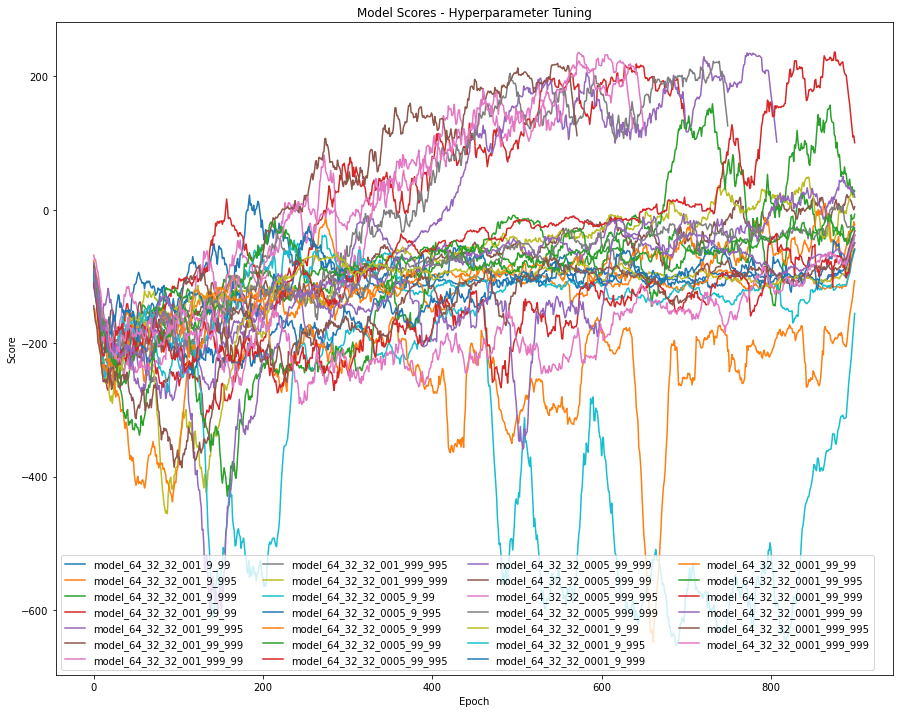

In [43]:
def smooth_data(data):
    box_pts = 21
    box = np.ones(box_pts)/box_pts
    return np.convolve(data, box, mode='same')

legendNames = []

figure = plt.figure(figsize=(15,12))

for modName in scores_hyperTuning:
    plt.plot(smooth_data(scores_hyperTuning[modName]))
    legendNames.append(modName)

plt.title("Model Scores - Hyperparameter Tuning")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend(legendNames, ncol=4)
plt.show()


From the plot above, it can be seen that there is a pretty wide spread of outcomes when tuning hyperparameters. The majority of configurations take a similar noisy trajectory toward convergence at a much slower rate than the six configurations who all seemed to converge between 550 and 800 epochs. As before, the table below condenses the information shown in the plot to just display the total training epochs needed to converge:

| Model_64_32_32 Hyperparemters    | Epochs To Completion |
|----------------------------------|----------------------|
| lr=.001, gamma=.9, decay=.99     | 900+                 |
| lr=.001, gamma=.9, decay=.995    | 900+                 |
| lr=.001, gamma=.9, decay=.999    | 900+                 |
| lr=.001, gamma=.99, decay=.99    | 701                  |
| lr=.001, gamma=.99, decay=.995   | 808                  |
| lr=.001, gamma=.99, decay=.999   | 900+                 |
| lr=.001, gamma=.999, decay=.99   | 638                  |
| lr=.001, gamma=.999, decay=.995  | 750                  |
| lr=.001, gamma=.999, decay=.999  | 900+                 |
| lr=.0005, gamma=.9, decay=.99    | 900+                 |
| lr=.0005, gamma=.9, decay=.995   | 900+                 |
| lr=.0005, gamma=.9, decay=.999   | 900+                 |
| lr=.0005, gamma=.99, decay=.99   | 900+                 |
| lr=.0005, gamma=.99, decay=.995  | 900+                 |
| lr=.0005, gamma=.99, decay=.999  | 900+                 |
| lr=.0005, gamma=.999, decay=.99  | 572                  |
| lr=.0005, gamma=.999, decay=.995 | 651                  |
| lr=.0005, gamma=.999, decay=.999 | 900+                 |
| lr=.0001, gamma=.9, decay=.99    | 900+                 |
| lr=.0001, gamma=.9, decay=.995   | 900+                 |
| lr=.0001, gamma=.9, decay=.999   | 900+                 |
| lr=.0001, gamma=.99, decay=.99   | 900+                 |
| lr=.0001, gamma=.99, decay=.995  | 900+                 |
| lr=.0001, gamma=.99, decay=.999  | 900+                 |
| lr=.0001, gamma=.999, decay=.99  | 900+                 |
| lr=.0001, gamma=.999, decay=.995 | 900+                 |
| lr=.0001, gamma=.999, decay=.999 | 900+                 |

You can tell from the table and from the plot that the majority of the configurations attempted did not perform well at all, with 21 out of the 27 runs timing out at the limit of 900 epochs. Of the 6 that actually converged, only one converged slightly quicker than the original training configuration of 0.0005, 0.99 and 0.995. That model, which has a hyperparameter configuration of 0.0005, 0.999 and 0.99, will be my final model selection that I will use to test the Lunar Lander game live!

### Final Model Display

In [26]:
def test_model(model, lr, gamma):
    env = gym.make('LunarLander-v2')
    
    agent = Agent(
                n_observations = env.observation_space.shape[0],
                n_actions = env.action_space.n,
                qnet_func = QNet_64_32_32,
                alpha = lr,
                gamma = gamma,
                replay_buff_size = REPLAY_BUFFER_SIZE,
                replay_buff_batch_size = REPLAY_BUFFER_BATCH_SIZE
            )
    agent.qnet_local.load_state_dict(torch.load(f"{model}.pth"))
    
    env = wrappers.Monitor(env, "./gym-results", force=True)
    s = env.reset()
    
    done = False
    
    while not done:
        a = agent.choose_action(s)
        s, _, done, __ = env.step(a)
    
    env.env.close()

In [14]:
REPLAY_BUFFER_SIZE = int(1e5)   # replay buffer size
REPLAY_BUFFER_BATCH_SIZE = 64   # minibatch size

test_model("model_64_32_32_0005_999_99", lr=.0005, gamma=.999)

2022-08-09 17:40:52.460 python[50295:2304421] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7faf83821790>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-09 17:40:52.461 python[50295:2304421] Warning: Expected min height of view: (<NSButton: 0x7faf8336dd90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-09 17:40:52.464 python[50295:2304421] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7faf8311a390>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-09 17:40:52.466 python[50295:2304421] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7faf831506a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


In [27]:
REPLAY_BUFFER_SIZE = int(1e5)   # replay buffer size
REPLAY_BUFFER_BATCH_SIZE = 64   # minibatch size

test_model("model_64_32_32", lr=.0005, gamma=.99)

2022-08-09 18:46:22.627 python[50597:2321522] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f9879dc5e60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-09 18:46:22.628 python[50597:2321522] Warning: Expected min height of view: (<NSButton: 0x7f9875e783d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-09 18:46:22.632 python[50597:2321522] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f9875e78a90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-08-09 18:46:22.634 python[50597:2321522] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f9875e7a6e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


# Discussion and Conclusion

If the results of the iterative model refinement show anything, it's that several factors have to line up just right for a DQN model to teach itself in as few epochs as possible. Even though all of the experimental combinations of hyperparameters covered a relatively small range of differences in the model, they had big consequences for how quickly the model converged on a solution, if it ever did at all! From the experiment, it became clear to me that the most important hyperparameter for stable learning is the learning rate. When it was set too small at 0.0001 not a single model converged! Additionally, a smaller discount factor of 0.9 never resulted in convergence.

Even more interesting to me than the outcome of iterating the hyperparameters was the process of deciding which neural network model was the best fit for the lunar lander environment. It was clear from the outcome that a model with one inner dense layer of size 32 did not properly fit the environment in an efficient way, resulting in an under-fitting of the data the oscillated heavily. On the other side of the spectrum, some models such as the 64-64-32 appeared to perform very well initially and then oscillate downward for a period of time before finally converging, which can be interpreted as over-fitting the data.

When testing the final model as a result of the hyperparameter tuning, it became evident that using the supposedly "tuned" parameters was good but not quite as good as the original test hyperparameters. So, while I ultimately settled on the 64-32-32 neural network as the best model to move forward with, I wonder if perhaps there is a different combination of hyperparameters that may have caused a different model to converge more quickly than the 64-32-32. I would also like to know whether the model I selected would work just as well on any of the other OpenAI gym environments.

In the end, I think my greatest constraint on this project was time. Both for being able to really research DQN to be able to use it in this project and for being able to train and play around with all the little details that go into making an excellent model. If I were to continue working on this project, I would attempt to apply my model to more OpenAI Gym environments to test its general ability to work in any environment. Additionally, I would invest in perhaps a different laptop, as I unfortunately discovered that my Intel MacBook with AMD graphics is perhaps the worst system for using PyTorch on, since it appears from Google searches that most of the effort is being spent toward integrating with NVidia GPUs or the new Apple Silicon chipsets.

My final thoughts: I'm glad I had the chance to learn about this up-and-coming field in computer science and am excited to continue to learn more as the field expands in the future.

## References

- https://www.gymlibrary.ml/environments/box2d/lunar_lander/
- https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html
- https://github.com/svpino/lunar-lander
